<a href="https://colab.research.google.com/github/Coldvoltt/Covid19_API/blob/master/movie_recomendation_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
import zipfile
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [ ]:
# Define the URL of the ZIP file you want to download
zip_file_url = 'https://files.grouplens.org/datasets/movielens/ml-latest-small.zip'

# Define the directory where you want to extract the contents
extraction_path = '/content/movies_data'

# Create the target directory if it doesn't exist
if not os.path.exists(extraction_path):
    os.makedirs(extraction_path)


In [ ]:
# Download the ZIP file
response = requests.get(zip_file_url)
with open(os.path.join(extraction_path, 'downloaded.zip'), 'wb') as file:
    file.write(response.content)

# Extract the contents of the ZIP file
with zipfile.ZipFile(os.path.join(extraction_path, 'downloaded.zip'), 'r') as archive:
    archive.extractall(extraction_path)

# Clean up: remove the downloaded ZIP file
os.remove(os.path.join(extraction_path, 'downloaded.zip'))


In [ ]:
# load movies and rating data
movies_data = pd.read_csv('movies_data/ml-latest-small/movies.csv')
ratings_data = pd.read_csv('movies_data/ml-latest-small/ratings.csv')

movies_data.head()


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
ratings_data.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
# Feature Engineering
## merge both tables
movie_db = pd.merge(movies_data,
                    ratings_data,
                    on = 'movieId',
                    how = 'inner')

movie_db.tail()

,movieId,title,genres,userId,rating,timestamp
100831,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,184,4.0,1537109082
100832,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,184,3.5,1537109545
100833,193585,Flint (2017),Drama,184,3.5,1537109805
100834,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,184,3.5,1537110021
100835,193609,Andrew Dice Clay: Dice Rules (1991),Comedy,331,4.0,1537157606


In [ ]:
# Consider Genres by converting into dummies
genre_dumies = movie_db['genres'].str.get_dummies('|')
genre_dumies.head()

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Drop useless genre (No genres listed)
genre_dumies = genre_dumies.drop('(no genres listed)', axis = 1)

In [ ]:
# Join genre dummies with main df and drop genre column
movie_db_new = pd.concat([movie_db, genre_dumies], axis = 1).drop(['genres','timestamp'], axis = 1)
movie_db_new.head()

,movieId,title,userId,rating,Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),1,4.0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,Toy Story (1995),5,4.0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1,Toy Story (1995),7,4.5,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,Toy Story (1995),15,2.5,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,Toy Story (1995),17,4.5,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
movie_db_new.shape

(100836, 23)

In [ ]:
# Count occurence of ratings using movieId
ratings_count = movie_db_new['movieId'].value_counts()
# index movies appearing more than 10 times
valid_movie_ids = ratings_count[ratings_count >= 10].index
# Filter the DataFrame to exclude movie IDs that appear less than 10 times
movie_db_new = movie_db_new[movie_db_new['movieId'].isin(valid_movie_ids)]

In [ ]:
# Convert userId into dummy variables
movie_dbs = pd.get_dummies(movie_db_new, columns = ['userId'], prefix = 'User')
movie_dbs.columns

Index(['movieId', 'title', 'rating', 'Action', 'Adventure', 'Animation',
       'Children', 'Comedy', 'Crime', 'Documentary',
       ...
       'User_601', 'User_602', 'User_603', 'User_604', 'User_605', 'User_606',
       'User_607', 'User_608', 'User_609', 'User_610'],
      dtype='object', length=632)

In [ ]:
movie_dbs.shape

(81116, 632)

In [ ]:
# A function to reduce sparcity.

def drop_high_zero_columns(df, threshold=98.5):
    """
    Check for columns with more than a specified percentage of zeros and drop them from the DataFrame.
    Args:
        df (pd.DataFrame): The input DataFrame.
        threshold (int): The percentage threshold for dropping columns (default is 96).
    Returns:
        pd.DataFrame: The DataFrame with high-zero columns removed.
    """
    # Calculate the percentage of zeros in each column
    zero_percentage = (df == 0).mean() * 100

    # Check for columns with over the specified threshold of zeros
    columns_to_drop = zero_percentage[zero_percentage > threshold].index

    # Drop the identified columns
    df = df.drop(columns=columns_to_drop)

    return df

In [ ]:
# Call the function to drop high-zero columns
df = drop_high_zero_columns(movie_dbs, threshold=99.5)
df.shape

(81116, 65)

In [ ]:
df.columns

Index(['movieId', 'title', 'rating', 'Action', 'Adventure', 'Animation',
       'Children', 'Comedy', 'Crime', 'Drama', 'Fantasy', 'Film-Noir',
       'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller',
       'War', 'Western', 'User_18', 'User_19', 'User_28', 'User_57', 'User_64',
       'User_68', 'User_91', 'User_105', 'User_111', 'User_140', 'User_177',
       'User_182', 'User_217', 'User_219', 'User_226', 'User_232', 'User_249',
       'User_274', 'User_288', 'User_298', 'User_305', 'User_307', 'User_318',
       'User_380', 'User_381', 'User_387', 'User_414', 'User_438', 'User_448',
       'User_474', 'User_477', 'User_480', 'User_483', 'User_489', 'User_525',
       'User_555', 'User_561', 'User_590', 'User_599', 'User_600', 'User_603',
       'User_606', 'User_608', 'User_610'],
      dtype='object')

In [ ]:
# Check for unique movies
print(f'There are {len(df.movieId.unique())} movies in the db')

There are 2269 movies in the db


In [ ]:
# We make a dictionary to map movie ID and title
movie_id_title = dict(zip(df['movieId'], df['title']))
print(movie_id_title)

{1: 'Toy Story (1995)', 2: 'Jumanji (1995)', 3: 'Grumpier Old Men (1995)', 5: 'Father of the Bride Part II (1995)', 6: 'Heat (1995)', 7: 'Sabrina (1995)', 9: 'Sudden Death (1995)', 10: 'GoldenEye (1995)', 11: 'American President, The (1995)', 12: 'Dracula: Dead and Loving It (1995)', 14: 'Nixon (1995)', 15: 'Cutthroat Island (1995)', 16: 'Casino (1995)', 17: 'Sense and Sensibility (1995)', 18: 'Four Rooms (1995)', 19: 'Ace Ventura: When Nature Calls (1995)', 20: 'Money Train (1995)', 21: 'Get Shorty (1995)', 22: 'Copycat (1995)', 23: 'Assassins (1995)', 24: 'Powder (1995)', 25: 'Leaving Las Vegas (1995)', 26: 'Othello (1995)', 28: 'Persuasion (1995)', 29: 'City of Lost Children, The (Cité des enfants perdus, La) (1995)', 31: 'Dangerous Minds (1995)', 32: 'Twelve Monkeys (a.k.a. 12 Monkeys) (1995)', 34: 'Babe (1995)', 36: 'Dead Man Walking (1995)', 39: 'Clueless (1995)', 41: 'Richard III (1995)', 44: 'Mortal Kombat (1995)', 45: 'To Die For (1995)', 46: 'How to Make an American Quilt (19

In [ ]:
# we drop the movie title.
df = df.drop(columns='title')

In [ ]:
df.head()

,movieId,rating,Action,Adventure,Animation,Children,Comedy,Crime,Drama,Fantasy,...,User_525,User_555,User_561,User_590,User_599,User_600,User_603,User_606,User_608,User_610
0,1,4.0,0,1,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,4.0,0,1,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,4.5,0,1,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,2.5,0,1,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,4.5,0,1,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Group the DataFrame by 'movieId' and calculate the mean for each group
df = df.groupby('movieId').mean().reset_index()

# Drop movies with ratings less than 3.0/5.0
main_df = df[df['rating'] > 3]

In [ ]:
main_df.shape

(1828, 64)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

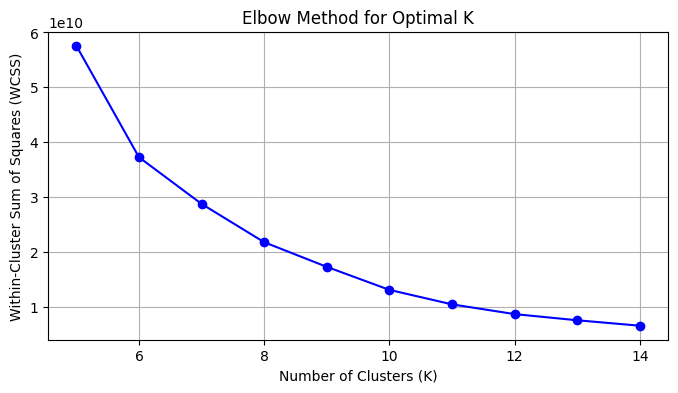

In [ ]:
## CLUSTERING

wcss = []
# Specify the range of K values to test
k_values = range(5, 15)  # You can adjust this range as needed

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(main_df)  # dataset
    wcss.append(kmeans.inertia_)  # WCSS for this K value

plt.figure(figsize=(8, 4))
plt.plot(k_values, wcss, marker='o', linestyle='-', color='b')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.grid()
plt.show()



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

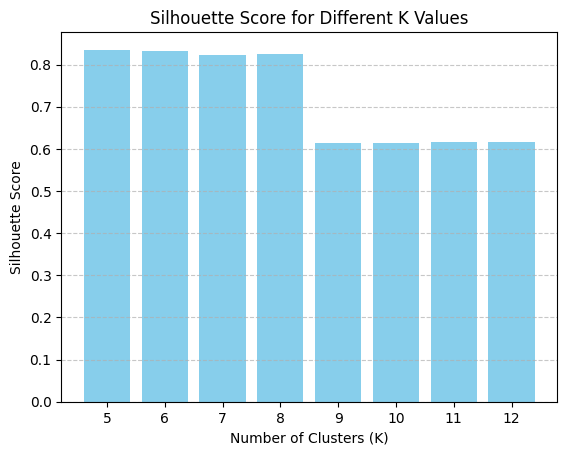

In [ ]:
from sklearn.metrics import silhouette_score

# Define the values of K you want to evaluate
k_values = [5, 6, 7, 8, 9, 10, 11, 12]
silhouette_scores = []

for k in k_values:
    # Create a KMeans model with the current K value
    kmeans = KMeans(n_clusters=k, random_state=0)

    # Fit the model to your data
    kmeans.fit(main_df)

    # Get the cluster labels
    labels = kmeans.labels_

    # Calculate the silhouette score for this K value
    silhouette_avg = silhouette_score(main_df, labels)

    # Append the silhouette score to the list
    silhouette_scores.append(silhouette_avg)

# Create a bar plot to visualize silhouette scores
plt.bar(k_values, silhouette_scores, color='skyblue')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different K Values')
plt.xticks(k_values)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [ ]:
# Choose the number of clusters (K)
K = 8

kmeans = KMeans(n_clusters=K)
labels = kmeans.fit_predict(main_df)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
# Add cluster labels to the DataFrame
main_df['cluster'] = labels

main_df['cluster'].unique()

<ipython-input-27-fe83c9082e92>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_df['cluster'] = labels


array([0, 7, 3, 6, 1, 4, 2, 5], dtype=int32)

In [ ]:
# mapping movie title from the save dictionary with the cluster df
main_df['title'] = main_df['movieId'].map(movie_id_title)

<ipython-input-28-40a029adc0d1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_df['title'] = main_df['movieId'].map(movie_id_title)


In [ ]:
main_df

,movieId,rating,Action,Adventure,Animation,Children,Comedy,Crime,Drama,Fantasy,...,User_561,User_590,User_599,User_600,User_603,User_606,User_608,User_610,cluster,title
0,1,3.920930,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.004651,0.004651,0.004651,0.004651,0.004651,0.004651,0.004651,0.004651,0,Toy Story (1995)
1,2,3.431818,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.009091,0.009091,0.009091,0.009091,0.000000,0.000000,0.009091,0.000000,0,Jumanji (1995)
2,3,3.259615,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.000000,0.019231,0.019231,0.000000,0.000000,0.000000,0.019231,0.000000,0,Grumpier Old Men (1995)
3,5,3.071429,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.020408,0.020408,0.000000,0.020408,0.000000,0.000000,0.000000,0.000000,0,Father of the Bride Part II (1995)
4,6,3.946078,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.009804,0.009804,0.009804,0.000000,0.009804,0.000000,0.000000,0.009804,0,Heat (1995)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2264,174055,3.423077,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.000000,0.000000,0.076923,0.000000,0.000000,0.000000,0.000000,0.000000,5,Dunkirk (2017)
2265,176371,3.805556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.055556,0.000000,0.000000,0.000000,0.000000,0.000000,5,Blade Runner 2049 (2017)
2266,177765,3.538462,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5,Coco (2017)
2267,179819,3.125000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5,Star Wars: The Last Jedi (2017)


In [ ]:
# Filter for movie title, c;luster and rating
titles_clusters = main_df[['title', 'cluster', 'rating']]
titles_clusters

,title,cluster,rating
0,Toy Story (1995),0,3.920930
1,Jumanji (1995),0,3.431818
2,Grumpier Old Men (1995),0,3.259615
3,Father of the Bride Part II (1995),0,3.071429
4,Heat (1995),0,3.946078
...,...,...,...
2264,Dunkirk (2017),5,3.423077
2265,Blade Runner 2049 (2017),5,3.805556
2266,Coco (2017),5,3.538462
2267,Star Wars: The Last Jedi (2017),5,3.125000


In [ ]:
titles_clusters[titles_clusters['cluster'] == 2].sort_values(by='rating', ascending=False)

,title,cluster,rating
2210,Wild Tales (2014),2,4.250000
2249,Spotlight (2015),2,4.157895
2230,Untitled Spider-Man Reboot (2017),2,4.156250
2225,Thor: Ragnarok (2017),2,4.025000
2208,The Imitation Game (2014),2,4.020000
2224,Avengers: Infinity War - Part I (2018),2,4.000000
2233,The Martian (2015),2,4.000000
2216,Kingsman: The Secret Service (2015),2,3.986111
2226,Guardians of the Galaxy 2 (2017),2,3.925926
2246,The Revenant (2015),2,3.903226


In [90]:

def get_top_movies(movie_title, df=titles_clusters, n=10):
    # Convert movie titles to lowercase for case-insensitive matching
    movie_title = movie_title.lower()

    closest_title = None

    # Create an empty list to store matching titles
    matching_titles = []

    # Iterate through the DataFrame to find partial string matches
    for title in df['title']:
        if movie_title in title.lower():
            matching_titles.append(title)

    if not matching_titles:
        return "No matching movie title found in the dataset."

    # Select the closest matching title based on partial string match
    title = matching_titles[0]

    # Find the cluster of the closest matching movie title
    cluster = df[df['title'] == title]['cluster'].values[0]

    # Filter the DataFrame to include only movies from the same cluster
    cluster_movies = df[df['cluster'] == cluster]

    # Exclude the closest match from the recommendations
    cluster_movies = cluster_movies[cluster_movies['title'].str.lower() != title.lower()]

    # Sort the remaining movies by rating in descending order and get the top n
    top_movies = cluster_movies.sort_values(by='rating', ascending=False).head(n)

    # Get the titles of the top movies
    top_movie_titles = top_movies['title']

    result = (f"Movie title closest match is: {title}.", f"Top {n} recommendations are:", top_movie_titles)

    return result




In [93]:
get_top_movies('Ultron')

('Movie title closest match is: Avengers: Age of Ultron (2015).',
 'Top 10 recommendations are:',
 2210                         Wild Tales (2014)
 2249                          Spotlight (2015)
 2230         Untitled Spider-Man Reboot (2017)
 2225                     Thor: Ragnarok (2017)
 2208                 The Imitation Game (2014)
 2224    Avengers: Infinity War - Part I (2018)
 2233                        The Martian (2015)
 2216       Kingsman: The Secret Service (2015)
 2226          Guardians of the Galaxy 2 (2017)
 2246                       The Revenant (2015)
 Name: title, dtype: object)